This notebook solves the tight binding model for the case of a single **spinless** fermions jumping aorund in a lattice. 

Main difference with the other notebook with lindblad is that here we have a single particle so we don't have to worry about fermion statistics.

Turns out that in this case it is far better to not worry about the destruction/annihilation operators of qutip (they are meant for particles with spin after all) and just express everything in the 1-particle bassis that we have.

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import pandas as pd
from sympy import symbols

from qutip import  *

In [95]:

def create_lindblad_op(Nsites, collapse_type):
    # creates the operators necesary for the non-unitrary dynamics i.e
    # collapse operatos and the operators for the expectation values
    # collapse_type = "number" or "ladder"
    collapse_ops = []
    expect_ops = []

    for site_j in range(0,Nsites):
        density_op = basis(Nsites, site_j)*basis(L,site_j).dag() 
        expect_ops.append(density_op)
        
        if collapse_type=="number":
            collapse_ops.append(np.sqrt(gamma)*density_op)
        else: 
            collapse_ops.append(np.sqrt(gamma)*basis(Nsites, site_j))
    
    return collapse_ops, expect_ops

def gen_gauss_init(l0, sigma, Nsites, k0=1):
    # creates a gaussian initial condition centerd on l0 with bandwidth sigma

    x = np.asarray(range(0,Nsites))
    coefs = ((np.sqrt(np.pi)*sigma)**(-0.5))*np.exp(-0.5*(x-l0)**2/(sigma)**2 )*np.exp(1j*k0*(x-l0))
    mag = np.dot(coefs,coefs)
    coefs = coefs/np.sqrt(mag)
    
    return coefs
    
    
def gen_psi0(init_coefs, Nsites):
    # creates the initial wave function from the init_coefs list
    # and the one particle basis vectors
    # create the density matrix from ONE particle basis states
    # list holding all possible 1-particle states
    basis_list = []
    
    for site_j in range(0,Nsites):
        # Put a particule in one of the sites
        basis_list.append(basis(Nsites, site_j))

    # create the initial state
    Psi0 = np.sum([init_coefs[j]*basis_list[j] for j in range(0,Nsites)])
    Psi0 = Psi0.unit()
    return Psi0

def gen_H(Nsites, bc):
    # creates a single particle in a lattice hamiltonian with bc as the boundary conditions
    # create the hamiltonian
    ident_tensor = identity(Nsites)
    H = 0*ident_tensor

    for site_j in range(0,Nsites-1):
        # the structure is ket*bra for each of the hamiltonian terms
        H += -0.5*J[site_j]*(basis(L,site_j+1)*basis(L,site_j).dag()+ basis(L,site_j)*basis(L,site_j+1).dag() )

    collapse_ops, expect_ops = create_lindblad_op(Nsites, collapse_op)
    # add the energy to also track it
    expect_ops.append(H)
    if(bc=="pbc"):
        # for periodic boundaries
        H += -0.5*J[0]*basis(Nsites, 0) * basis(Nsites, Nsites-1).dag()
        H += -0.5*J[0]*basis(Nsites, Nsites-1) * basis(Nsites, 0).dag()
        
    return H

def get_Pt(state_list):
    # calcualte the purity as a function of time
    # state_list is a list of Qobj density matrix from the result obj in qutip
    Purity = []
    for i in range(0,len(state_list)):
        r2 = state_list[i]**2
        Purity.append(r2.tr())
    return Purity



# Two Particle Basis

In [3]:
def get_n_particle_configuration(n_particles, length):
    # THIS PART IS TAKEN FROM CHRISTIANS CODE
    """
    Get coefficients for a state of `n_particles` on a chain of `length`.

    The state on the chain will be of dimension 2^`length`, but only the
    coefficients corresponding to a state with exactly `n_particles` will be
    non-zero.

    Parameters
    ----------
    n_particles : int
    length : int

    Returns
    -------
    pandas.DataFrame
        Rows: label the basis states.
        Columns: [1, ..., `length`]: label the sites.
            'occupations': labels sites with a particle.
            'n_particles': number of particles in corresponding state.
            'coefficient': \alpha_{occupations}, a symbol for nice sympy
                representation of the state. Will be non-zero only for states
                with `n_particles`.

    """
    # There are 2^length basis states for a chain of length `length`. If we
    # translate these to a binary representation, we can interpret the result as
    # an array of occupation numbers: no (0) particle or one (1) particle.

    # here we do all possible combinations of occupation numbers for the given sites
    # regardless of particle number
    bit_basis_states = np.array([np.array([(index >> i) & 1 for i in range(length - 1, -1, -1)])
                                 for index in np.arange(2**length)])
    df = pd.DataFrame(bit_basis_states)

    # columns should be site labels (then the bit representation has the meaning
    # of no (0) or one (1) particle on the sites)
    df.columns = range(1, length + 1)
    # check where the particles are for each of the basis states
    df['occupations'] = df.apply(lambda row: ''.join(df.columns[row == 1].values.astype(str)),
                                 axis=1)
    # summ the number of particles in each configuration
    df['n_particles'] = df.drop('occupations', axis=1).sum(axis=1)
    # in the end, the quantum state will have coefficients that label where the
    # particles sit
    df['coefficient'] = symbols([f'alpha_{i}' for i in df['occupations']])
    # the coefficients corresponding to states with more or less particles are
    # set to zero
    df.loc[df['n_particles'] != n_particles, 'coefficient'] = 0
    
    return df

In [4]:
N_particles = 2
L = 4

In [5]:
basis_df = get_n_particle_configuration(N_particles, L)
# get only the basis states corresponding to the configuration we want
basis_df = basis_df[basis_df['coefficient']!=0]
basis_df['coefficient'].to_list()

[alpha_34, alpha_24, alpha_23, alpha_14, alpha_13, alpha_12]

In [6]:
# turn the correct strings into kets
basis_list = []
curr_df = basis_df[basis_df.columns[:L]]
curr_df

,1,2,3,4
3,0,0,1,1
5,0,1,0,1
6,0,1,1,0
9,1,0,0,1
10,1,0,1,0
12,1,1,0,0


In [7]:
for i in range(0,len(curr_df)):
    list_config = list(curr_df.iloc[i,:])
    basis_list.append(list_config)

In [8]:
list_config = list(curr_df.iloc[2,:])
list_config

[0, 1, 1, 0]

# Single Localized particle

In [118]:
L = 15 # Num of sites
D = 2 # local hilbert space
gamma = 0.3 # the dephasing term for the collapse operators
max_t = 40 # maximum time
tsteps = 200 # number of time steps
J = np.ones(L) # interaction
J_contact = 1
# Here we could place a a point contact if we want
#J[L-4] = J_contact
J[0] = J_contact
collapse_op = "number" # either "number" or "ladder"
boundary_cond = "fixed" # either "fixed" or "pbc"
centered_in = 2 

initial_conditions = np.zeros(L) # initial conditions of the density matrix
initial_conditions[centered_in] = 1.0


In [119]:
# initialize state
psi0 = gen_psi0(initial_conditions, L)
rho = ket2dm(psi0)

H = gen_H(L, boundary_cond )
collapse_ops, expect_ops = create_lindblad_op(L, collapse_op)
# add the energy to also track it
expect_ops.append(H)

H

Quantum object: dims=[[15], [15]], shape=(15, 15), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.  -0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. ]
 [-0.5  0.  -0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. ]
 [ 0.  -0.5  0.  -0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. ]
 [ 0.   0.  -0.5  0.  -0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. ]
 [ 0.   0.   0.  -0.5  0.  -0.5  0.   0.   0.   0.   0.   0.   0.   0.
   0. ]
 [ 0.   0.   0.   0.  -0.5  0.  -0.5  0.   0.   0.   0.   0.   0.   0.
   0. ]
 [ 0.   0.   0.   0.   0.  -0.5  0.  -0.5  0.   0.   0.   0.   0.   0.
   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.5  0.  -0.5  0.   0.   0.   0.   0.
   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.5  0.  -0.5  0.   0.   0.   0.
   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.5  0.  -0.5  0.   0.   0.
   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.5  0.  -0.5  0.   0.
   0. ]
 [ 0.   0.   0.   0.   0.   0.

In [131]:
i= 2

(1/gamma)*(collapse_ops[i].dag()*collapse_ops[i]*rho).tr()

0.9999999999999998

In [12]:
times = np.linspace(0.0, max_t, tsteps)
result = mesolve(H, rho, times, c_ops=collapse_ops , e_ops=expect_ops, options={"store_states": True})

result

<Result
  Solver: mesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.00019693374633789062
    preparation time: 0.0002701282501220703
    run time: 0.20523691177368164
    solver: 'Master Equation Evolution'
    num_collapse: 15
  Time interval: [0.0, 40.0] (200 steps)
  Number of e_ops: 16
  States saved.
>

In [13]:
Pt = get_Pt(result.states)

0.06691940790947354


Text(0, 0.5, 'Purity')

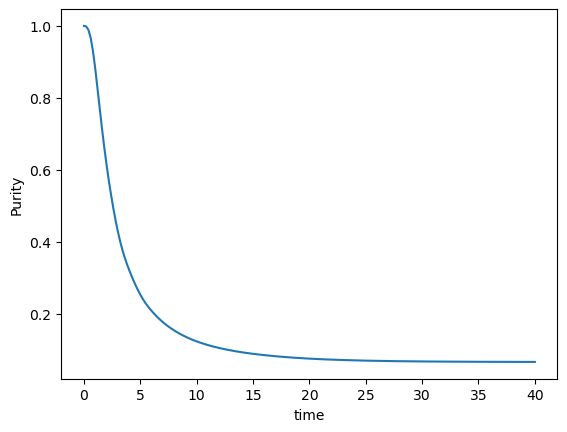

In [14]:
print(min(Pt))

plt.plot(times,Pt)
plt.xlabel("time")
plt.ylabel("Purity")

Text(0, 0.5, 'Energy')

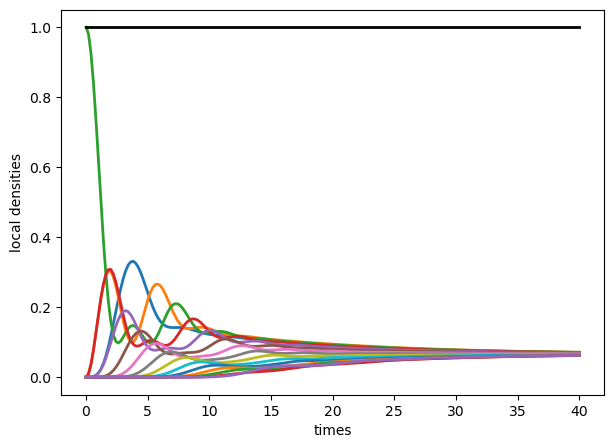

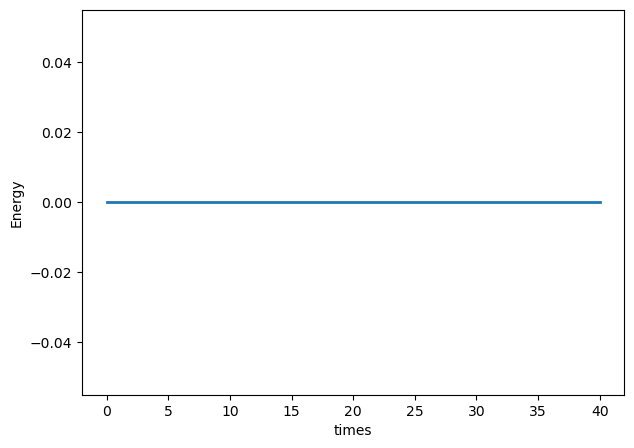

In [15]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

# plot
for i in range(0,len(result.expect)-1):
    ax.plot(times, result.expect[i], linewidth=2.0)
    
# get the total particle number
# get the sum of the local densities
n_tot = np.sum(result.expect, axis=0)
ax.plot(times, n_tot, c='black', linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("local densities")

#plt.savefig("../plots/densities_L={}_Jc={}.pdf".format(L,J_contact))

fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(times, result.expect[-1], linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("Energy")



Text(50.722222222222214, 0.5, 'densities')

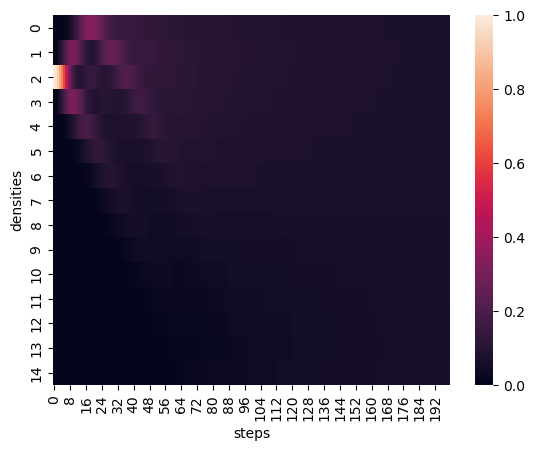

In [16]:
xt = np.linspace(0,max_t,5)
# plot the occupations as a heatmap with lattice site in the y axis and time on the x
ax = sns.heatmap(result.expect[:-1])
ax.set_xlabel("steps")
ax.set_ylabel("densities")

#plt.savefig("../plots/trajectory_L={}_Jc={}.png".format(L,J_contact), dpi=300)


# With Gaussian initial state as a function of system size

here we estimate how decoherence time and rate changes as a function of system sizer

In [32]:
def get_decoherence_rate(rho0,collapse_ops):
    # Decoherence rate as defined in Eq.(3)  
    # from "Decoherence rate in random Lindlbad dynamics" (https://arxiv.org/abs/2402.04705)

    term_list = [2*((rho0**2)*collapse_ops[i].dag()*collapse_ops[i]).tr() - \
         (rho0*collapse_ops[i].dag()*rho0*collapse_ops[i]).tr() for i in range(0,L)]
    
    return 2*gamma*np.sum(np.real(term_list))

In [88]:
D = 2 # local hilbert space dimension
gamma = 0.01 # the dephasing term for the collapse operators
max_t = 50 # maximum time
tsteps = 300 # number of time steps
times = np.linspace(0.0, max_t, tsteps)

collapse_op = "number" # either "number" or "ladder"
boundary_cond = "fixed" # either "fixed" or "pbc"

centered_in = 0.0 # which site the gaussian wave packet is centered at
band_width = 2.0 # bandwidth og wave packet. Higher number means less localized
K0 = np.pi/2 # initial velocity of the wave packet this does not matter here i think

L_list = range(2,33,3)

In [89]:
# time evolution
result_list = []
Pt_list = [] # purity
D_list = [] # decoherence rate
for L in L_list:

    J = np.ones(L) # interaction
    J_contact = 1.0
    # Here we could place a a point contact if we want
    J[L-4] = J_contact
    J[L-3] = J_contact

    initial_conditions = gen_gauss_init(centered_in,band_width, L,k0=K0)
    # initialize initial gaussian state
    psi0 = gen_psi0(initial_conditions, L)
    rho = ket2dm(psi0)
    
    H = gen_H(L, boundary_cond )
    collapse_ops, expect_ops = create_lindblad_op(L, collapse_op)
    # add the energy to also track it
    expect_ops.append(H)
    
    result = mesolve(H, rho, times, c_ops=collapse_ops , e_ops=expect_ops,options={"store_states": True})

    # purity
    Pt_list.append(get_Pt(result.states))
    # decoherence rate alwast depedns on the initial state only
    D_list.append( get_decoherence_rate(rho,collapse_ops) )

    result_list.append(result)
    

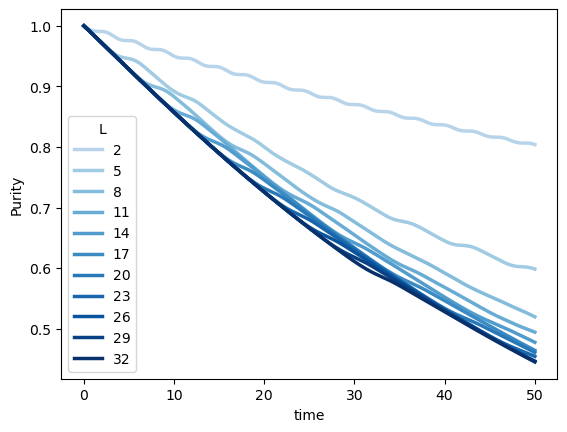

In [90]:
cmap = plt.cm.Blues(np.linspace(0.3,1,len(Pt_list)))
                   
for i in range(0,len(Pt_list)):
    plt.plot(times, Pt_list[i],color=cmap[i], linewidth=2.5, label=L_list[i])

plt.xlabel("time")
plt.ylabel("Purity")
plt.legend(title="L")

In [91]:
# plotting the decoherence rate and assoicated quantitites
# decoherence time
D_time = 1/np.asarray(D_list)
# Ehrenfest theorem tells us that he decoherence length would be 
D_len = 2*J[0]*np.sin(K0)*D_time


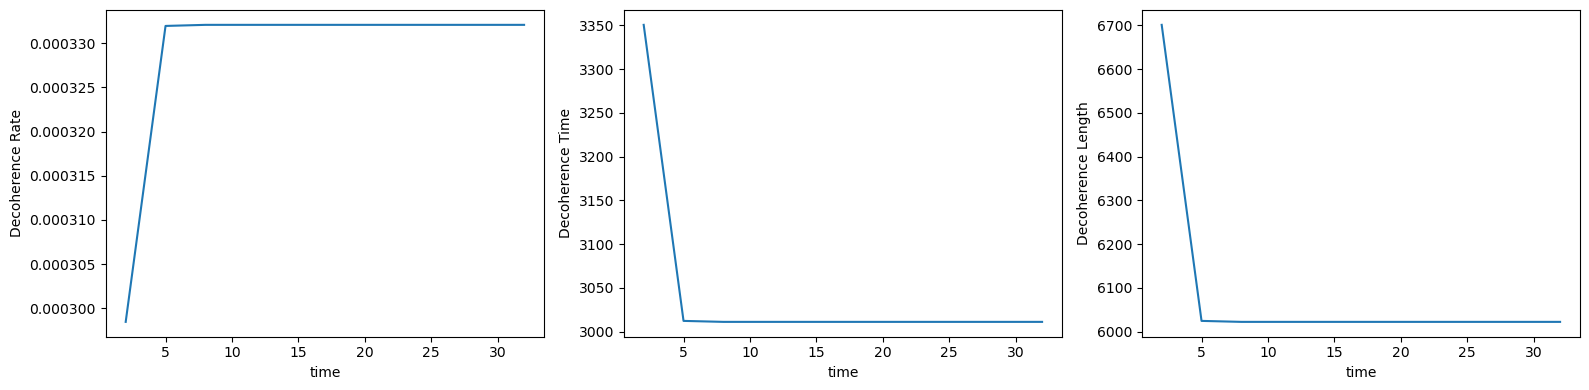

In [92]:
fig, ax = plt.subplots(1,3,figsize=(16,4))

ax[0].plot(L_list, D_list)
ax[1].plot(L_list, D_time)
ax[2].plot(L_list, D_len)

ax[0].set_xlabel("time")
ax[1].set_xlabel("time")
ax[2].set_xlabel("time")

ax[0].set_ylabel("Decoherence Rate")
ax[1].set_ylabel("Decoherence Time")
ax[2].set_ylabel("Decoherence Length")

plt.tight_layout()

### Example system

Text(58.222222222222214, 0.5, 'densities')

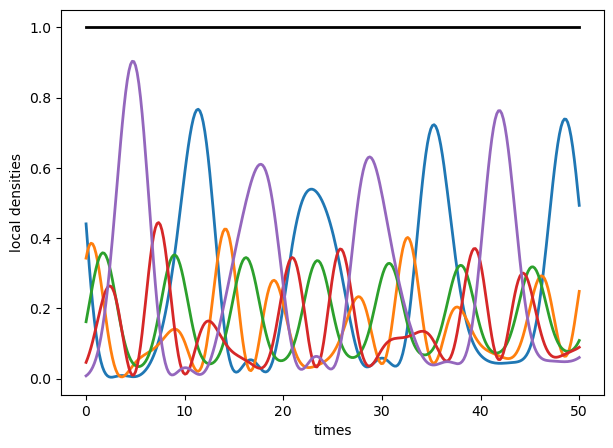

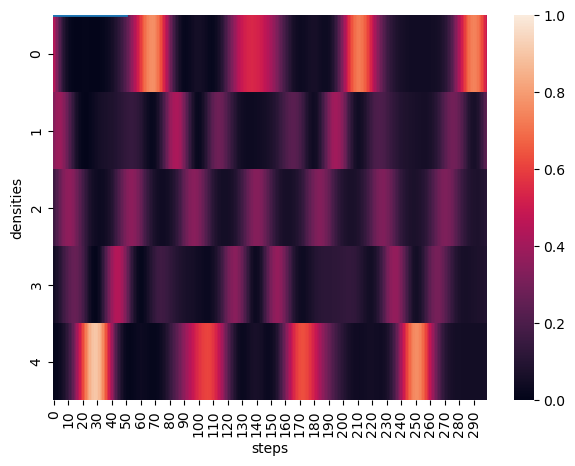

In [93]:
result =  result_list[1]

fig, ax = plt.subplots(1,1, figsize=(7,5))

# plot
for i in range(0,len(result.expect)-1):
    ax.plot(times, result.expect[i], linewidth=2.0)
    
# get the total particle number
# get the sum of the local densities remember that at -1 we have the energy
n_tot = np.sum(result.expect[:-1], axis=0)
ax.plot(times, n_tot, c='black', linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("local densities")

plt.savefig("../plots/densities_L={}_Jc={}_bw={}.pdf".format(L,J_contact,band_width))

fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(times, result.expect[-1], linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("Energy")

xt = np.linspace(0,max_t,5)
# plot the occupations as a heatmap with lattice site in the y axis and time on the x
ax = sns.heatmap(result.expect[:-1], vmin=0, vmax=1)
ax.set_xlabel("steps")
ax.set_ylabel("densities")